In [1]:
!git clone https://github.com/Jackie-2000/team4project.git

Cloning into 'team4project'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.tokenize import word_tokenize
import gensim
from gensim import models
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
word2vec_path = '../GoogleNews-vectors-negative300.bin'
w2v_model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [4]:

def load_files(train_path, eval_path, debug=False, n=2):
  """
  Numpy file loading
  args:
  train_path (str) -> train file path
  eval_path (str) -> eval file path
  debug (Bool ) -> (optional) print debug statements
  n (int) -> number of examples to be printed
  """
  # file_loading
  wp_train = np.load(train_path, allow_pickle=True)
  wp_eval = np.load(eval_path, allow_pickle=True)

  if debug:

    print(f"train dtype: {wp_train.dtype}\n")
    print(f"train shape: {wp_train.shape}\n")
    print(f"train first {n} samples: {wp_train[:n]}\n")
    print(f"eval dtype: {wp_eval.dtype}\n")
    print(f"eval shape: {wp_eval.shape}\n")
    print(f"eval first {n} samples: {wp_eval[:n]}")


  return wp_train, wp_eval


wp_train, wp_eval = load_files('./team4project/data/WP-train.npy', './team4project/data/SP_eval_data_for_practice.npy', debug=True)
sp_train, sp_eval = load_files('./team4project/data/SP-train.npy', './team4project/data/SP_eval_data_for_practice.npy', debug=True)

train dtype: object

train shape: (396,)

train first 2 samples: [{'id': 'WP-0', 'question': 'How do you spell COW in thirteen letters?', 'answer': 'SEE O DOUBLE YOU.', 'distractor1': 'COWCOWCOWCOWW', 'distractor2': 'SEE OH DEREFORD', 'distractor(unsure)': 'None of above.', 'label': 1, 'choice_list': ['SEE OH DEREFORD', 'SEE O DOUBLE YOU.', 'COWCOWCOWCOWW', 'None of above.'], 'choice_order': [2, 0, 1, 3]}
 {'id': 'WP-0_SR', 'question': 'In thirteen letters, how do you spell COW?', 'answer': 'SEE O DOUBLE YOU.', 'distractor1': 'COWCOWCOWCOWW', 'distractor2': 'SEE OH DEREFORD', 'distractor(unsure)': 'None of above.', 'label': 2, 'choice_list': ['SEE OH DEREFORD', 'COWCOWCOWCOWW', 'SEE O DOUBLE YOU.', 'None of above.'], 'choice_order': [2, 1, 0, 3]}]

eval dtype: object

eval shape: (120,)

eval first 2 samples: [{'question': 'Everyone called him "Batman," but he knew nothing about bats and thought they were disgusting. He still cherished being referred to as Batman! How is this possible?

In [5]:
sp_train[0]

{'id': 'SP-0',
 'question': 'Mr. and Mrs. Mustard have six daughters and each daughter has one brother. But there are only 9 people in the family, how is that possible?',
 'answer': 'Each daughter shares the same brother.',
 'distractor1': 'Some daughters get married and have their own family.',
 'distractor2': 'Some brothers were not loved by family and moved away.',
 'distractor(unsure)': 'None of above.',
 'label': 1,
 'choice_list': ['Some daughters get married and have their own family.',
  'Each daughter shares the same brother.',
  'Some brothers were not loved by family and moved away.',
  'None of above.'],
 'choice_order': [1, 0, 2, 3]}

In [6]:
wp_train[0]

{'id': 'WP-0',
 'question': 'How do you spell COW in thirteen letters?',
 'answer': 'SEE O DOUBLE YOU.',
 'distractor1': 'COWCOWCOWCOWW',
 'distractor2': 'SEE OH DEREFORD',
 'distractor(unsure)': 'None of above.',
 'label': 1,
 'choice_list': ['SEE OH DEREFORD',
  'SEE O DOUBLE YOU.',
  'COWCOWCOWCOWW',
  'None of above.'],
 'choice_order': [2, 0, 1, 3]}

In [7]:
pad_seq = "<pad>"

In [8]:
def df_converter(data):
  """
     Data formatting for the dataset and conversion to df
  """

  df = pd.DataFrame()
  q, a1, a2, a3, a4, c = [],[],[],[],[],[]

  for dp in tqdm(data):
    c.append(dp['choice_order'].index(0))
    a1.append(dp['choice_list'][dp['choice_order'][0]])
    a2.append(dp['choice_list'][dp['choice_order'][1]])
    a3.append(dp['choice_list'][dp['choice_order'][2]])
    a4.append(dp['choice_list'][dp['choice_order'][3]])
    q.append(dp['question'])
  df['question'], df['answer1'], df['answer2'], df['answer3'], df['answer4'], df['choice'] = q, a1, a2, a3, a4, c

  return df

In [9]:
df = df_converter(wp_train)
df = pd.concat([df, df_converter(sp_train)])
#eval_df = df_converter(wp_eval)

100%|████████████████████████████████████████████████████████████████████████████| 507/507 [00:00<00:00, 1131123.47it/s]


In [10]:
df.shape

(903, 6)

In [11]:
df.tail()

,question,answer1,answer2,answer3,answer4,choice
502,"Ten pears hung high, ten men passed past, Each...",Other men didn't see the pear.,EACH is the name of one of the men.,Other men can't reach the pear.,None of above.,2
503,There were twenty boys with different names in...,Other boys don't know how to write.,Other boys don't have names.,All is the name of one of the boys.,None of above.,1
504,"The more you take, the more you leave behind",Footsteps.,Love.,Money.,None of above.,1
505,"The more you take, the more you abandon.",Footsteps.,Love.,Money.,None of above.,1
506,You are running so fast but you're not getting...,Treadmill.,Country road.,High way.,None of above.,1


In [12]:
train_df, valid_df = train_test_split(df, test_size=0.2)

In [13]:
train_df.head()

,question,answer1,answer2,answer3,answer4,choice
455,How can you enter a exam session and have the ...,You have to be a teacher.,You have to prepate for the whole year.,You have to ask teacher for the asnwer.,None of above.,0
497,A submarine is moving west at a speed of 30 kn...,"The submarine is moving west, the bubbles woul...",There are no bubbles. Modern submarines are de...,"The current is moving east, the bubbles would ...",None of above.,2
119,"You are in Wall's World, where there is only o...",Each word in Wall's World must contain less th...,Each word in Wall's World must contain more th...,Each word in Wall's World must be symmetry.\n,None of above.,1
282,How did the champ fix the leaky facet?,With a monkey wrench.,With an adjustable wrench.,With a stubby wrench.,None of above.,1
387,Fred is listening to the radio when it suddenl...,The car required more electricity to speed up ...,All electricity on the earth is cut down.,Fred was driving his car through a tunnel.,None of above.,1


In [14]:
train_df.shape

(722, 6)

In [15]:
train_df['question'] = train_df['question'].apply(lambda x: "<START> " +x + " <END>")
valid_df['question'] = valid_df['question'].apply(lambda x: "<START> " +x + " <END>")

In [16]:
train_df.head()


,question,answer1,answer2,answer3,answer4,choice
455,<START> How can you enter a exam session and h...,You have to be a teacher.,You have to prepate for the whole year.,You have to ask teacher for the asnwer.,None of above.,0
497,<START> A submarine is moving west at a speed ...,"The submarine is moving west, the bubbles woul...",There are no bubbles. Modern submarines are de...,"The current is moving east, the bubbles would ...",None of above.,2
119,"<START> You are in Wall's World, where there i...",Each word in Wall's World must contain less th...,Each word in Wall's World must contain more th...,Each word in Wall's World must be symmetry.\n,None of above.,1
282,<START> How did the champ fix the leaky facet?...,With a monkey wrench.,With an adjustable wrench.,With a stubby wrench.,None of above.,1
387,<START> Fred is listening to the radio when it...,The car required more electricity to speed up ...,All electricity on the earth is cut down.,Fred was driving his car through a tunnel.,None of above.,1


In [17]:
train_df.choice.value_counts()

choice
1    235
2    224
0    221
3     42
Name: count, dtype: int64

In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/snoronha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
"this is a test sentence".split()

['this', 'is', 'a', 'test', 'sentence']

In [20]:
class VocabEmbedding(object):
    def __init__(self, w2v_model):
      self.w2v = w2v_model
      self.w2v.add_vector('<START>', np.random.uniform(low=-1, high=1.0, size=(300,)))
      self.w2v.add_vector('<END>', np.random.uniform(low=-1, high=1.0, size=(300,)))
      self.w2v.add_vector('<pad>', np.random.uniform(low=-1, high=1.0, size=(300,)))
      self.w2v.add_vector('<unk>', np.random.uniform(low=-1, high=1.0, size=(300,)))

      bos = self.w2v.key_to_index.get('<START>')
      eos = self.w2v.key_to_index.get('<END>')
      pad = self.w2v.key_to_index.get('<pad>')
      unk = self.w2v.key_to_index.get('<unk>')

      self.bos_index = bos
      self.eos_index = eos
      self.pad_index = pad
      self.unk_index = unk


    def tokenizer(self, text):

        return [i for i in text.split(' ')]




    def encode(self, text, questions=True):

        sequence = []
        if questions:
          tokens = self.tokenizer(text)
        else:
          tokens = [c for word in text.split(' ') for c in word]  # converting to characters

        for token in tokens:
            index = self.w2v.key_to_index.get(token, self.unk_index)
            sequence.append(index)

        return sequence


    def create_padded_tensor(self, sequences, max_length=256):
        tensor = torch.full((len(sequences), max_length), self.pad_index, dtype=torch.long)



        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):

                tensor[i][j] = token

        return tensor

In [21]:
class TaggerDataset(Dataset):
    def __init__(self, data, text_sequencer):

        self.data = data

        self.input_sequencer = text_sequencer


    def __getitem__(self, index):
        q, a1, a2, a3, a4, c = self.data[index]

        question = self.input_sequencer.encode(q)
        answer1 = self.input_sequencer.encode(a1, questions=False)
        answer2 = self.input_sequencer.encode(a2, questions=False)
        answer3 = self.input_sequencer.encode(a3, questions=False)
        answer4 = self.input_sequencer.encode(a4, questions=False)


        return torch.tensor(question).to(device),torch.tensor(answer1).to(device), \
              torch.tensor(answer2).to(device), torch.tensor(answer3).to(device), \
                torch.tensor(answer4).to(device), torch.tensor(c).to(device)


    def __len__(self):
        return len(self.data)

In [22]:
train_data = [(row['question'], row['answer1'],
               row['answer2'], row['answer3'],
               row['answer4'], row['choice']
               ) for i,row in train_df.iterrows()]

val_data = [(row['question'], row['answer1'],
               row['answer2'], row['answer3'],
               row['answer4'], row['choice']) for i, row in valid_df.iterrows()]

In [23]:
text_sequencer = VocabEmbedding(w2v_model)

/home/snoronha/projects/243/env/lib/python3.9/site-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [24]:
train_dataset = TaggerDataset(train_data, text_sequencer)
val_dataset = TaggerDataset(val_data, text_sequencer)

In [25]:
next(iter(train_dataset))

(tensor([3000000,    1190,      50,      43,    2045, 3000003,    8168,    1207,
         3000003,      21,      11,    3953,    6914,      60,    2207,    1249,
               1,      11, 3000003, 3000001], device='cuda:0'),
 tensor([  11969,   11538,   16205,   23199, 3000003,    6878,    4211,    7726,
           11538,    7332,    4211, 3000003,    7726,    4211, 3000003,    7969,
           23199,    4211,   17919, 3000003], device='cuda:0'),
 tensor([  11969,   11538,   16205,   23199, 3000003,    6878,    4211,    7726,
           11538,    9311,   17919,    4211,    9311, 3000003,    7726,    4211,
           17251,   11538,   17919,    7726,   23199,    4211,   15389,   23199,
           11538,   15775,    4211,   17891,    4211, 3000003,   17919, 3000003],
        device='cuda:0'),
 tensor([  11969,   11538,   16205,   23199, 3000003,    6878,    4211,    7726,
           11538, 3000003,    1280,   11429,    7726,    4211, 3000003,    7969,
           23199,    4211,   17919,

In [26]:
batch_size=16

In [27]:
def prepare_batch(batch, input_sequencer, max_length_answers):
    questions, a1, a2, a3, a4, labels = zip(*batch)
    q = input_sequencer.create_padded_tensor(questions)
    a1 = input_sequencer.create_padded_tensor(a1, max_length=max_length_answers)
    a2 = input_sequencer.create_padded_tensor(a2, max_length=max_length_answers)
    a3 = input_sequencer.create_padded_tensor(a3, max_length=max_length_answers)
    a4 = input_sequencer.create_padded_tensor(a4, max_length=max_length_answers)

    a1 = torch.cat((q,a1) , dim=1)
    a2 = torch.cat((q,a2) , dim=1)
    a3 = torch.cat((q,a3) , dim=1)
    a4 = torch.cat((q,a4) , dim=1)


    return (a1.to(device), a2.to(device), a3.to(device), a4.to(device), torch.Tensor(labels).to(device))

In [28]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, 256))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, 256), shuffle=False)

In [29]:
device

device(type='cuda')

In [41]:
class GRUAttentionModel(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_classes, num_heads, w2v_model, kernel_size=3, stride=1, freeze_embedding=True):
        super(GRUAttentionModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(w2v_model.vectors), padding_idx=1, freeze=freeze_embedding)

        self.hidden_size = hidden_size

        self.lstm = nn.GRU(input_size=300,
                            hidden_size=hidden_size,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.num_heads = num_heads
    
        self.drop = nn.Dropout(p=0.5) # added for dropout        

        # Fully connected layers for classification
        self.fc = nn.Linear(2*hidden_size, 128)
        self.dropout = nn.Dropout(0.1)
        
        self.fc1 = nn.Linear(hidden_size*4, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

        
        self.multihead_attn = nn.MultiheadAttention(hidden_size*4, num_heads) # multiheaded attention layer
        
        # w_key = torch.tensor(torch.rand(), dtype=torch.float32)
        # w_query = torch.tensor(torch.rand(), dtype=torch.float32)
        # w_value = torch.tensor(w_value.rand(), dtype=torch.float32)
   
    def lstm_forward(self, embeddings):
        packed_output, _ = self.lstm(embeddings)

        
            
        out_forward = packed_output[:, -1, :self.hidden_size]

        out_reverse = packed_output[:, 0, self.hidden_size:]
        
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_features = self.drop(out_reduced)
        text_features = self.fc(text_features)        
        return text_features

    
    def forward(self, a1, a2, a3, a4, debug=False):
        a1_embed = self.embedding(a1)
        a2_embed = self.embedding(a2)
        a3_embed = self.embedding(a3)
        a4_embed = self.embedding(a4)

        #Running CNN through the question
        if debug:
          print('q embedding size', a1_embed.size())
          print('q embedding with added dimension size', a1_embed.unsqueeze(1).size())

    
        #packed_input1 = pack_padded_sequence(a1_embed, , batch_first=True, enforce_sorted=False)

        a1_flat = self.lstm_forward(a1_embed)
        a2_flat = self.lstm_forward(a2_embed)
        a3_flat = self.lstm_forward(a3_embed)
        a4_flat = self.lstm_forward(a4_embed)
        if debug:
            print('a1 flat size', a1_flat.size())
            print('a2 flat size', a2_flat.size())        


        combined_tensor = torch.cat((a1_flat, a2_flat, a3_flat, a4_flat), dim=1)
        

        if debug: print('combined tensor size', combined_tensor.size())

        attention_output , _ = self.multihead_attn(combined_tensor, combined_tensor, combined_tensor)


        if debug: print('attention output',attention_output.size())

        

            
        out = nn.functional.relu(self.fc1(attention_output))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [43]:
import gc
try:
  del model
  gc.collect()
  torch.cuda.empty_cache()
except:
  gc.collect()
  torch.cuda.empty_cache()

In [44]:
512*4

2048

In [45]:

model = GRUAttentionModel(300, 128, 4, 8, w2v_model,kernel_size=7, stride=2, freeze_embedding=True).to(device)
#model = LSTM_Model(output_size, tag_sequencer.pad_index, rnn_hidden_size=hidden_size, num_layers=30, w2v_weights=torch.FloatTensor(w2v_model.vectors)).to(device)

print('trainable parameters',count_parameters(model))



for i, batch in tqdm(enumerate(train_loader)):

    logits = model(batch[0], batch[1], batch[2], batch[3], debug=True)
    print(logits)
    break


trainable parameters 1446852


0it [00:00, ?it/s]

q embedding size torch.Size([16, 512, 300])
q embedding with added dimension size torch.Size([16, 1, 512, 300])
a1 flat size torch.Size([16, 128])
a2 flat size torch.Size([16, 128])
combined tensor size torch.Size([16, 512])
attention output torch.Size([16, 512])
tensor([[-0.0475,  0.0083, -0.0703,  0.1350],
        [-0.0383,  0.0271, -0.0734,  0.1547],
        [-0.0368,  0.0175, -0.0738,  0.1316],
        [-0.0404,  0.0239, -0.0674,  0.1497],
        [-0.0303,  0.0160, -0.0849,  0.1278],
        [-0.0544,  0.0238, -0.0621,  0.1284],
        [-0.0352,  0.0052, -0.0817,  0.1325],
        [-0.0491, -0.0014, -0.0848,  0.1314],
        [-0.0461,  0.0139, -0.0733,  0.1386],
        [-0.0316,  0.0199, -0.0760,  0.1254],
        [-0.0368,  0.0206, -0.0685,  0.1503],
        [-0.0362,  0.0240, -0.0703,  0.1532],
        [-0.0454,  0.0228, -0.0648,  0.1472],
        [-0.0479,  0.0259, -0.0708,  0.1272],
        [-0.0184,  0.0220, -0.0631,  0.1734],
        [-0.0522,  0.0410, -0.0585,  0.1413]],

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for a1, a2, a3, a4, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(a1, a2, a3, a4)
        loss = criterion(outputs, labels.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)


    # Calculate accuracy on test set after each epoch
    model.eval()
    correct = 0
    total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for a1, a2, a3, a4, labels in val_loader:
            outputs = model(a1, a2, a3, a4)
            loss = criterion(outputs, labels.type(torch.LongTensor).to(device))
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            # print('********************************************')
            # print('\n\nValidations', labels)
            # print('\n\nPredictions',predicted)
            # print('\n********************************************\n')

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {epoch_loss:.4f} Test Accuracy: {accuracy:.2f}%")

torch.save(model.state_dict(), '/content/drive/MyDrive/CNN_trained_model.pth')

Epoch [1/100] Loss: 48.3821 Test Accuracy: 28.18%
Epoch [2/100] Loss: 6.2708 Test Accuracy: 33.70%
Epoch [3/100] Loss: 1.3251 Test Accuracy: 32.04%
Epoch [4/100] Loss: 1.2996 Test Accuracy: 32.04%
Epoch [5/100] Loss: 1.2738 Test Accuracy: 32.04%
Epoch [6/100] Loss: 1.2648 Test Accuracy: 32.04%
Epoch [7/100] Loss: 1.2612 Test Accuracy: 32.04%
Epoch [8/100] Loss: 1.2578 Test Accuracy: 32.04%
Epoch [9/100] Loss: 1.2569 Test Accuracy: 32.04%
Epoch [10/100] Loss: 1.2558 Test Accuracy: 32.04%
Epoch [11/100] Loss: 1.2571 Test Accuracy: 32.04%
Epoch [12/100] Loss: 1.2552 Test Accuracy: 32.04%
Epoch [13/100] Loss: 1.2558 Test Accuracy: 32.04%
Epoch [14/100] Loss: 1.2553 Test Accuracy: 32.04%
Epoch [15/100] Loss: 1.2708 Test Accuracy: 32.04%
Epoch [16/100] Loss: 1.2710 Test Accuracy: 32.04%
Epoch [17/100] Loss: 1.2554 Test Accuracy: 32.04%
Epoch [18/100] Loss: 1.2555 Test Accuracy: 32.04%
Epoch [19/100] Loss: 1.2559 Test Accuracy: 32.04%
Epoch [20/100] Loss: 1.2558 Test Accuracy: 32.04%
Epoch [2

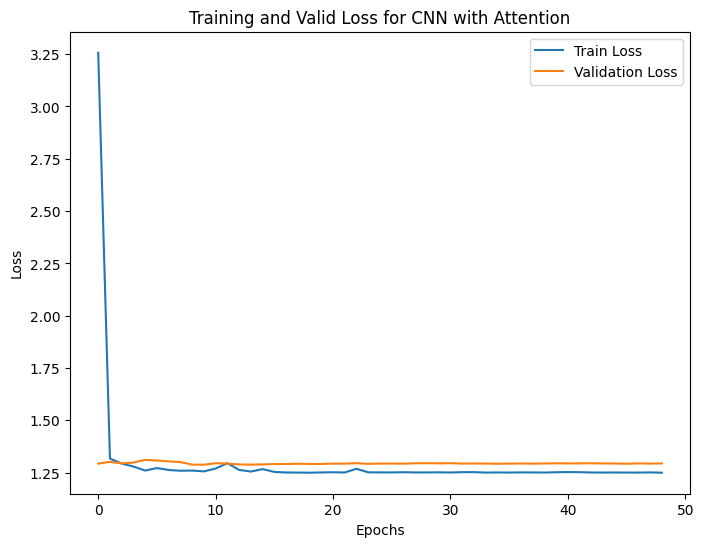

In [163]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Valid Loss for CNN with Attention')
plt.legend()
plt.show()